In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/hard-drive-test-data/harddrive.csv


# Importing needed libraries

In [2]:
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from hyperopt import hp, fmin, tpe, Trials
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.datasets import make_regression

# Loading dataset

In [3]:
df = pd.read_csv('../input/hard-drive-test-data/harddrive.csv')
print(df.shape)
df.head()

(3179295, 95)


,date,serial_number,model,capacity_bytes,failure,smart_1_normalized,smart_1_raw,smart_2_normalized,smart_2_raw,smart_3_normalized,...,smart_250_normalized,smart_250_raw,smart_251_normalized,smart_251_raw,smart_252_normalized,smart_252_raw,smart_254_normalized,smart_254_raw,smart_255_normalized,smart_255_raw
0,2016-01-01,MJ0351YNG9Z0XA,Hitachi HDS5C3030ALA630,1.482490e-311,0,100,0,135.0,108.0,143,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2016-01-01,Z305B2QN,ST4000DM000,1.976651e-311,0,113,54551400,NaN,NaN,96,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2016-01-01,MJ0351YNG9Z7LA,Hitachi HDS5C3030ALA630,1.482490e-311,0,100,0,136.0,104.0,124,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2016-01-01,MJ0351YNGABYAA,Hitachi HDS5C3030ALA630,1.482490e-311,0,100,0,136.0,104.0,137,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2016-01-01,WD-WMC4N2899475,WDC WD30EFRX,1.482490e-311,0,200,0,NaN,NaN,175,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
df = df.loc[:, ~df.isnull().all()]
print(df.shape)

(3179295, 91)


In [5]:
# number of hdd
print("number of hdd:", df['serial_number'].value_counts().shape) 

# number of different types of harddrives
print("number of different harddrives", df['model'].value_counts().shape)

number of hdd: (65993,)
number of different harddrives (69,)


In [6]:
failed_hdds = df.loc[df.failure==1]["serial_number"]
len(failed_hdds)

215

In [7]:
df = df.loc[df["serial_number"].isin(failed_hdds)]
df.shape

(5490, 91)

In [8]:
df["end_date"] = df.groupby("serial_number")["date"].transform("max")

In [9]:
df["end_date"] = pd.to_datetime(df["end_date"])
df["date"] = pd.to_datetime(df["date"])

In [10]:
df["date_diff"] = df["end_date"] - df["date"]
df["date_diff"].describe()

count                          5490
mean     49 days 09:18:25.573770492
std      44 days 09:17:21.395230515
min                 0 days 00:00:00
25%                 7 days 00:00:00
50%                21 days 00:00:00
75%                95 days 00:00:00
max               119 days 00:00:00
Name: date_diff, dtype: object

In [11]:
df.head()

,date,serial_number,model,capacity_bytes,failure,smart_1_normalized,smart_1_raw,smart_2_normalized,smart_2_raw,smart_3_normalized,...,smart_250_normalized,smart_250_raw,smart_251_normalized,smart_251_raw,smart_252_normalized,smart_252_raw,smart_254_normalized,smart_254_raw,end_date,date_diff
376,2016-01-01,Z300ZST1,ST4000DM000,1.976651e-311,0,120,240872800,NaN,NaN,91,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-01-17,16 days
1657,2016-01-01,9VY8TCAV,ST3160318AS,7.907120e-313,0,111,38605541,NaN,NaN,97,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-04-09,99 days
1895,2016-01-01,W300BG0H,ST4000DM000,1.976651e-311,0,118,190147064,NaN,NaN,91,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-04-18,108 days
2900,2016-01-01,W300J6FX,ST4000DM000,1.976651e-311,0,115,85258376,NaN,NaN,92,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-04-09,99 days
3204,2016-01-01,Z3014A4S,ST4000DM000,1.976651e-311,0,116,101976792,NaN,NaN,91,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-01-10,9 days


In [12]:
df.isnull().sum()

date                       0
serial_number              0
model                      0
capacity_bytes             0
failure                    0
                        ... 
smart_252_raw           4973
smart_254_normalized    4921
smart_254_raw           4921
end_date                   0
date_diff                  0
Length: 93, dtype: int64

In [13]:
df[df["serial_number"]=='Z300ZST1'].shape

(18, 93)

In [14]:
df_notna = df[df.columns[~(df.isna().sum().values/len(df) > 0.05)]]

In [15]:
df_notna.dropna(inplace=True)

/tmp/ipykernel_47/748473798.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_notna.dropna(inplace=True)


In [16]:
df = df_notna.copy()

In [17]:
df.reset_index(inplace=True, drop=True)

In [18]:
df.isnull().sum()

date                    0
serial_number           0
model                   0
capacity_bytes          0
failure                 0
smart_1_normalized      0
smart_1_raw             0
smart_3_normalized      0
smart_3_raw             0
smart_4_normalized      0
smart_4_raw             0
smart_5_normalized      0
smart_5_raw             0
smart_7_normalized      0
smart_7_raw             0
smart_9_normalized      0
smart_9_raw             0
smart_10_normalized     0
smart_10_raw            0
smart_12_normalized     0
smart_12_raw            0
smart_188_raw           0
smart_192_normalized    0
smart_192_raw           0
smart_193_normalized    0
smart_193_raw           0
smart_194_normalized    0
smart_194_raw           0
smart_197_normalized    0
smart_197_raw           0
smart_198_normalized    0
smart_198_raw           0
smart_199_normalized    0
smart_199_raw           0
smart_240_raw           0
smart_241_raw           0
smart_242_raw           0
end_date                0
date_diff   

In [19]:
df.head()

,date,serial_number,model,capacity_bytes,failure,smart_1_normalized,smart_1_raw,smart_3_normalized,smart_3_raw,smart_4_normalized,...,smart_197_raw,smart_198_normalized,smart_198_raw,smart_199_normalized,smart_199_raw,smart_240_raw,smart_241_raw,smart_242_raw,end_date,date_diff
0,2016-01-01,Z300ZST1,ST4000DM000,1.976651e-311,0,120,240872800,91,0,100,...,0,100,0,200,0,8.206430e-320,1.146406e-313,9.784107e-313,2016-01-17,16 days
1,2016-01-01,W300BG0H,ST4000DM000,1.976651e-311,0,118,190147064,91,0,100,...,0,100,0,200,0,7.857538e-310,1.249659e-313,6.394443e-313,2016-04-18,108 days
2,2016-01-01,W300J6FX,ST4000DM000,1.976651e-311,0,115,85258376,92,0,100,...,0,100,0,200,0,1.000186e-319,1.324438e-313,6.040397e-313,2016-04-09,99 days
3,2016-01-01,Z3014A4S,ST4000DM000,1.976651e-311,0,116,101976792,91,0,100,...,8,100,8,200,0,8.351192e-320,1.063035e-313,1.019657e-312,2016-01-10,9 days
4,2016-01-01,Z4D045CF,ST6000DX000,2.964974e-311,0,116,101694695,88,0,100,...,0,100,0,200,0,9.331476e-310,1.260229e-313,1.176377e-310,2016-04-05,95 days


In [20]:
df = df.drop(['date', 'serial_number', 'model','end_date'], axis=1)
df.head()

,capacity_bytes,failure,smart_1_normalized,smart_1_raw,smart_3_normalized,smart_3_raw,smart_4_normalized,smart_4_raw,smart_5_normalized,smart_5_raw,...,smart_197_normalized,smart_197_raw,smart_198_normalized,smart_198_raw,smart_199_normalized,smart_199_raw,smart_240_raw,smart_241_raw,smart_242_raw,date_diff
0,1.976651e-311,0,120,240872800,91,0,100,10,100,0,...,100,0,100,0,200,0,8.206430e-320,1.146406e-313,9.784107e-313,16 days
1,1.976651e-311,0,118,190147064,91,0,100,10,100,0,...,100,0,100,0,200,0,7.857538e-310,1.249659e-313,6.394443e-313,108 days
2,1.976651e-311,0,115,85258376,92,0,100,8,100,0,...,100,0,100,0,200,0,1.000186e-319,1.324438e-313,6.040397e-313,99 days
3,1.976651e-311,0,116,101976792,91,0,100,9,100,0,...,100,8,100,8,200,0,8.351192e-320,1.063035e-313,1.019657e-312,9 days
4,2.964974e-311,0,116,101694695,88,0,100,17,100,0,...,100,0,100,0,200,0,9.331476e-310,1.260229e-313,1.176377e-310,95 days


In [21]:
Y = df["date_diff"].dt.days
X = df.drop(["date_diff"],axis=1)

In [22]:
from sklearn.model_selection import train_test_split

# Assuming you have your features in X and target variable in y
# Replace this with your actual data

# Perform train-test split (adjust test_size and random_state as needed)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Print the shapes of the resulting splits
print("Shapes - X_train:", X_train.shape, "X_test:", X_test.shape, "y_train:", y_train.shape, "y_test:", y_test.shape)


Shapes - X_train: (4272, 34) X_test: (1068, 34) y_train: (4272,) y_test: (1068,)


Random Forest MSE: 24.742705805243446
Random Forest R^2 score: 0.9876112851447929


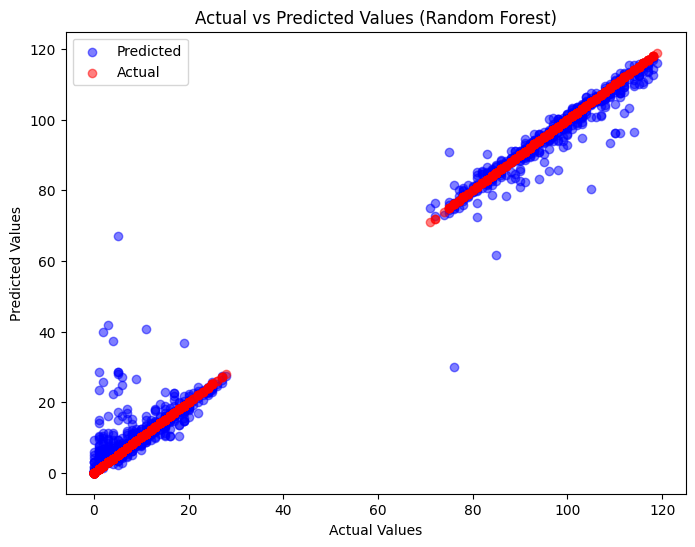

In [23]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Creating Random Forest Regressor
RF_model = RandomForestRegressor(random_state=1)
RF_model.fit(X_train, y_train)

# Predicting on test data
y_pred_RF = RF_model.predict(X_test)

# Calculating Mean Squared Error
mse_RF = mean_squared_error(y_test, y_pred_RF)
print("Random Forest MSE:", mse_RF)

# Calculating R^2 score
score_RF = RF_model.score(X_test, y_test)
print("Random Forest R^2 score:", score_RF)

# Visualizing Actual vs Predicted values with different colors
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_RF, alpha=0.5, label='Predicted', color='blue')
plt.scatter(y_test, y_test, alpha=0.5, label='Actual', color='red')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values (Random Forest)')
plt.legend()
plt.show()

# Decision Tree Without HyperParameter Tuning

Decision Tree MSE: 71.49438202247191
Decision Tree R^2 score: 0.9642026413926827


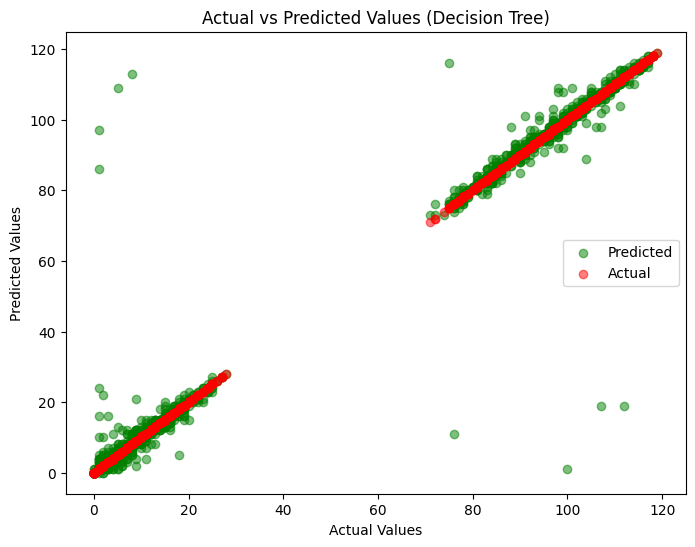

In [24]:
from sklearn.tree import DecisionTreeRegressor

# Creating Decision Tree Regressor
DT_model = DecisionTreeRegressor(random_state=1)
DT_model.fit(X_train, y_train)

# Predicting on test data
y_pred_DT = DT_model.predict(X_test)

# Calculating Mean Squared Error
mse_DT = mean_squared_error(y_test, y_pred_DT)
print("Decision Tree MSE:", mse_DT)

# Calculating R^2 score
score_DT = DT_model.score(X_test, y_test)
print("Decision Tree R^2 score:", score_DT)

# Visualizing Actual vs Predicted values with different colors
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_DT, alpha=0.5, label='Predicted', color='green')
plt.scatter(y_test, y_test, alpha=0.5, label='Actual', color='red')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values (Decision Tree)')
plt.legend()
plt.show()


# Random Forest Parameter Tuning With Hyperopt

In [25]:
seed=2
def objective(params):
    est=int(params['n_estimators'])
    md=int(params['max_depth'])
    msl=int(params['min_samples_leaf'])
    mss=int(params['min_samples_split'])
    model=RandomForestRegressor(n_estimators=est,max_depth=md,min_samples_leaf=msl,min_samples_split=mss)
    model.fit(X_train,y_train)
    pred=model.predict(X_test)
    score=mean_squared_error(y_test,pred)
    return score

def optimize(trial):
    params={'n_estimators':hp.uniform('n_estimators',10,100),
           'max_depth':hp.uniform('max_depth',5,20),
           'min_samples_leaf':hp.uniform('min_samples_leaf',1,5),
           'min_samples_split':hp.uniform('min_samples_split',2,6)}
    best=fmin(fn=objective,space=params,algo=tpe.suggest,trials=trial,max_evals=150,rstate=np.random.default_rng(seed=2))
    return best

trial=Trials()
best=optimize(trial)

100%|██████████| 150/150 [03:51<00:00,  1.54s/trial, best loss: 47.471565572204156]


In [26]:
print(best)

for t in trial.trials[:2]:
    print (t)

{'max_depth': 19.524164091193963, 'min_samples_leaf': 1.5301813618824844, 'min_samples_split': 3.6124832090772996, 'n_estimators': 58.59626858860088}
{'state': 2, 'tid': 0, 'spec': None, 'result': {'loss': 104.49807589552675, 'status': 'ok'}, 'misc': {'tid': 0, 'cmd': ('domain_attachment', 'FMinIter_Domain'), 'workdir': None, 'idxs': {'max_depth': [0], 'min_samples_leaf': [0], 'min_samples_split': [0], 'n_estimators': [0]}, 'vals': {'max_depth': [17.06974354546972], 'min_samples_leaf': [2.3918730381022115], 'min_samples_split': [2.9289857075688754], 'n_estimators': [65.86711620344198]}}, 'exp_key': None, 'owner': None, 'version': 0, 'book_time': datetime.datetime(2024, 5, 10, 9, 31, 18, 590000), 'refresh_time': datetime.datetime(2024, 5, 10, 9, 31, 20, 245000)}
{'state': 2, 'tid': 1, 'spec': None, 'result': {'loss': 610.8515156620324, 'status': 'ok'}, 'misc': {'tid': 1, 'cmd': ('domain_attachment', 'FMinIter_Domain'), 'workdir': None, 'idxs': {'max_depth': [1], 'min_samples_leaf': [1],

In [27]:
TID=[t['tid'] for t in trial.trials]
Loss=[t['result']['loss'] for t in trial.trials]
maxd=[t['misc']['vals']['max_depth'][0] for t in trial.trials]
nest=[t['misc']['vals']['n_estimators'][0] for t in trial.trials]
min_ss=[t['misc']['vals']['min_samples_split'][0] for t in trial.trials]
min_sl=[t['misc']['vals']['min_samples_leaf'][0] for t in trial.trials]

hyperopt_rfr=pd.DataFrame({'tid':TID,'loss':Loss,
                          'max_depth':maxd,'n_estimators':nest,
                          'min_samples_split':min_ss, 'min_samples_leaf':min_sl})

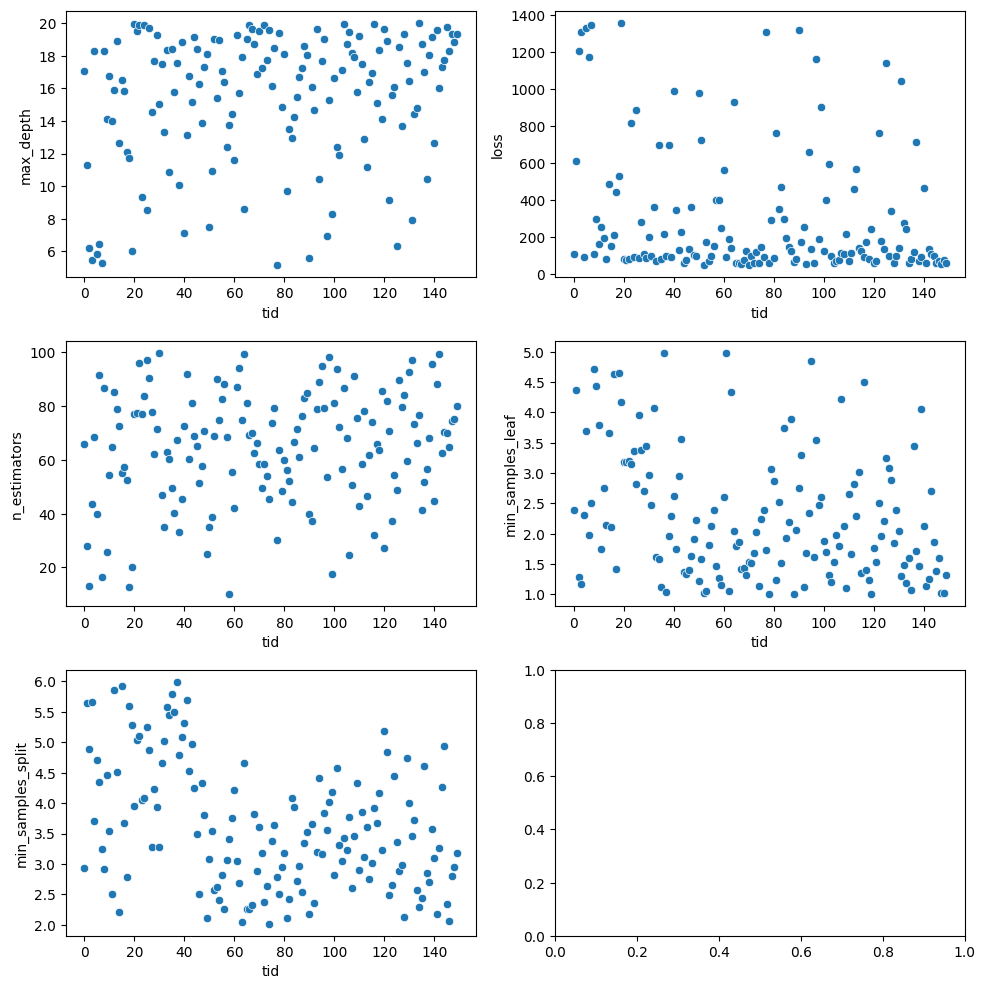

In [28]:
plt.subplots(3,2,figsize=(10,10))
plt.subplot(3,2,1)
sns.scatterplot(x='tid',y='max_depth',data=hyperopt_rfr)
plt.subplot(3,2,2)
sns.scatterplot(x='tid',y='loss',data=hyperopt_rfr)
plt.subplot(3,2,3)
sns.scatterplot(x='tid',y='n_estimators',data=hyperopt_rfr)
plt.subplot(3,2,4)
sns.scatterplot(x='tid',y='min_samples_leaf',data=hyperopt_rfr)
plt.subplot(3,2,5)
sns.scatterplot(x='tid',y='min_samples_split',data=hyperopt_rfr)

plt.tight_layout()

In [29]:
best_params = {
    'n_estimators': int(best['n_estimators']),
    'max_depth': int(best['max_depth']),
    'min_samples_leaf': int(best['min_samples_leaf']),
    'min_samples_split': int(best['min_samples_split']),
    'random_state': 2  # Assuming you want to set the random state
}

rfr_opt = RandomForestRegressor(**best_params)
rfr_opt.fit(X_train,y_train)
pred_rfr_opt=rfr_opt.predict(X_test)
score_rfr_opt=mean_squared_error(y_test,pred_rfr_opt)
score = rfr_opt.score(X_test, y_test)
print("MSE Random Forest After HyperParameter Tuning With Hyperopt: ", score_rfr_opt)
print("R^2 Score Random Forest After Hyperparameter Tuning With Hyperopt: ", score)

MSE Random Forest After HyperParameter Tuning With Hyperopt:  58.64054029898816
R^2 Score Random Forest After Hyperparameter Tuning With Hyperopt:  0.9706385817930434


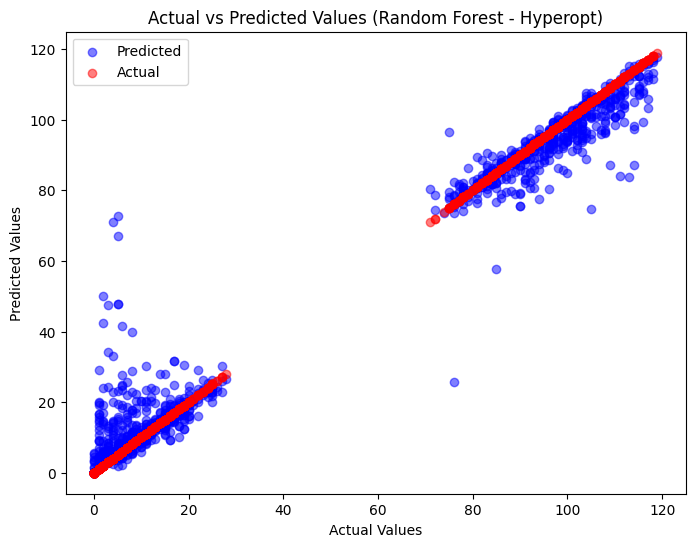

In [30]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, pred_rfr_opt, alpha=0.5, label='Predicted', color='blue')
plt.scatter(y_test, y_test, alpha=0.5, label='Actual', color='red')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values (Random Forest - Hyperopt)')
plt.legend()
plt.show()

Linear Regression MSE: 1839.763829868211
KNN MSE: 1796.0913483146069
SVR MSE: 2888.862282038295
Gradient Boosting MSE: 823.1131999351211
Linear Regression R^2 score: 0.0788271230897094
KNN R^2 score: 0.10069400883961954
SVR R^2 score: -0.4464582552063059
Gradient Boosting R^2 score: 0.5878658216357121


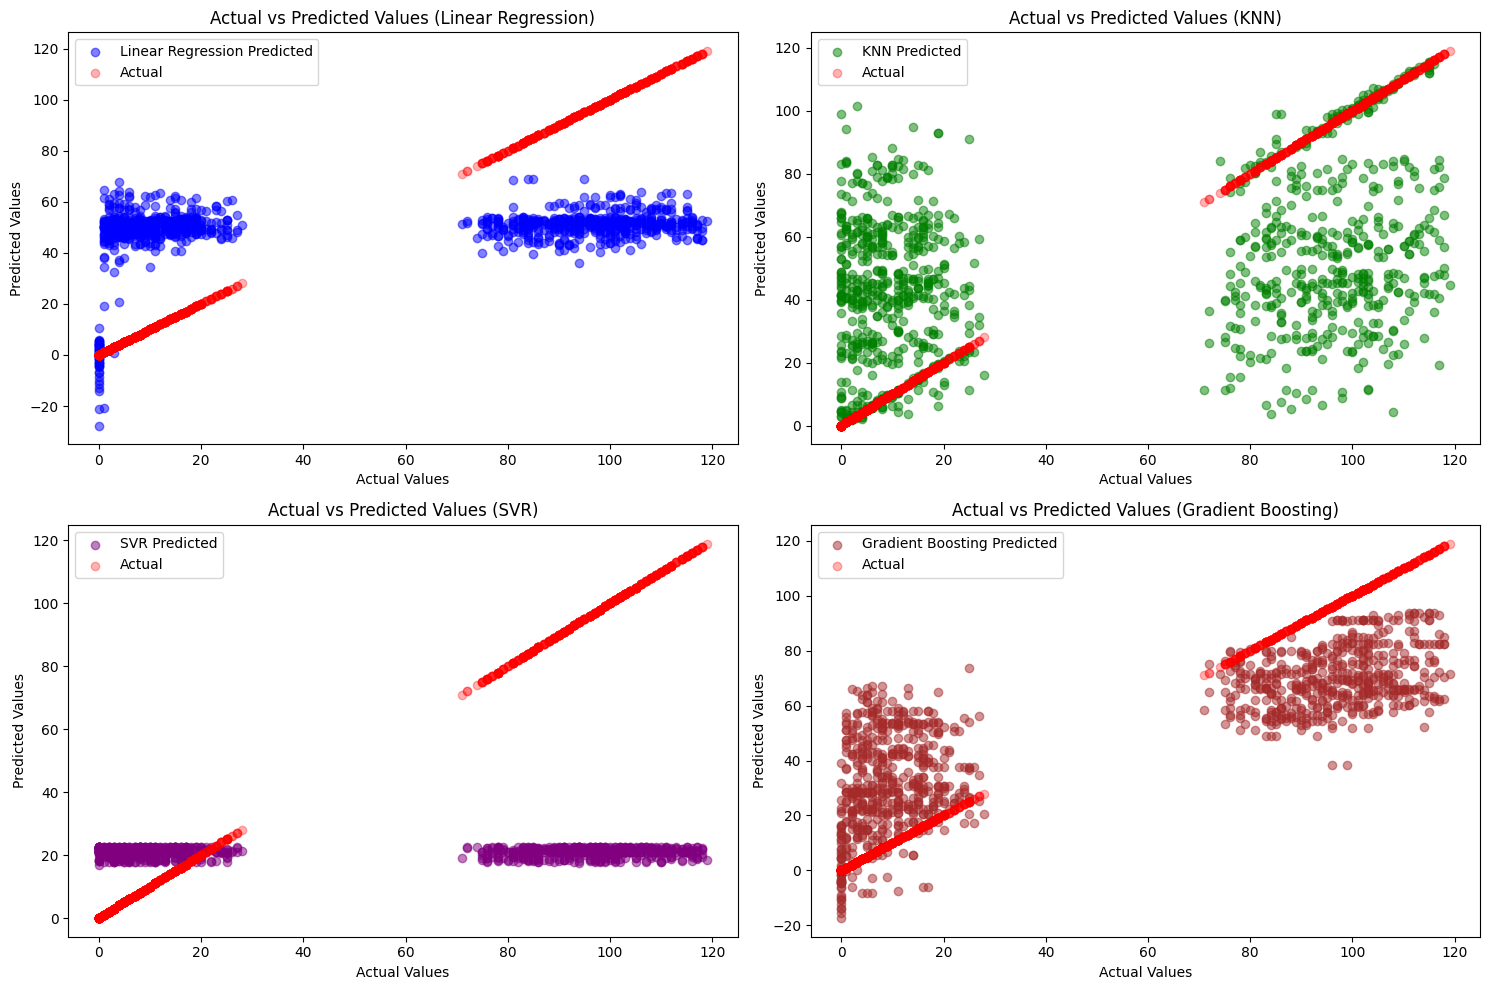

In [31]:
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Initialize models
LR_model = LinearRegression()
KNN_model = KNeighborsRegressor()
SVR_model = SVR()
GB_model = GradientBoostingRegressor(random_state=1)

# Fit models
LR_model.fit(X_train, y_train)
KNN_model.fit(X_train, y_train)
SVR_model.fit(X_train, y_train)
GB_model.fit(X_train, y_train)

# Predict on test data
y_pred_LR = LR_model.predict(X_test)
y_pred_KNN = KNN_model.predict(X_test)
y_pred_SVR = SVR_model.predict(X_test)
y_pred_GB = GB_model.predict(X_test)

# Calculate Mean Squared Error
mse_LR = mean_squared_error(y_test, y_pred_LR)
mse_KNN = mean_squared_error(y_test, y_pred_KNN)
mse_SVR = mean_squared_error(y_test, y_pred_SVR)
mse_GB = mean_squared_error(y_test, y_pred_GB)
print("Linear Regression MSE:", mse_LR)
print("KNN MSE:", mse_KNN)
print("SVR MSE:", mse_SVR)
print("Gradient Boosting MSE:", mse_GB)

# Calculate R^2 score
score_LR = LR_model.score(X_test, y_test)
score_KNN = KNN_model.score(X_test, y_test)
score_SVR = SVR_model.score(X_test, y_test)
score_GB = GB_model.score(X_test, y_test)
print("Linear Regression R^2 score:", score_LR)
print("KNN R^2 score:", score_KNN)
print("SVR R^2 score:", score_SVR)
print("Gradient Boosting R^2 score:", score_GB)

# Visualization setup
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
models = [(y_pred_LR, 'Linear Regression'), (y_pred_KNN, 'KNN'), 
          (y_pred_SVR, 'SVR'), (y_pred_GB, 'Gradient Boosting')]
colors = ['blue', 'green', 'purple', 'brown']
labels = ['Predicted', 'Actual']

# Plot each model
for ax, (predictions, title), color in zip(axes.flatten(), models, colors):
    ax.scatter(y_test, predictions, alpha=0.5, label=f'{title} Predicted', color=color)
    ax.scatter(y_test, y_test, alpha=0.3, label='Actual', color='red')
    ax.set_xlabel('Actual Values')
    ax.set_ylabel('Predicted Values')
    ax.set_title(f'Actual vs Predicted Values ({title})')
    ax.legend()

plt.tight_layout()
plt.show()


In [32]:
from sklearn.model_selection import GridSearchCV

# Define the model
knn = KNeighborsRegressor()

# Create a dictionary of all values we want to test for n_neighbors
param_grid = {'n_neighbors': np.arange(1, 25)}

# Use gridsearch to test all values for n_neighbors
knn_gscv = GridSearchCV(knn, param_grid, cv=5)

# Fit model to data
knn_gscv.fit(X_train, y_train)

# Check top performing n_neighbors value
best_n_neighbors = knn_gscv.best_params_['n_neighbors']

# Using the best parameter to fit the model
knn_best = KNeighborsRegressor(n_neighbors=best_n_neighbors)
knn_best.fit(X_train, y_train)
y_pred_knn_best = knn_best.predict(X_test)
print("Optimized KNN R^2 score:", knn_best.score(X_test, y_test))


Optimized KNN R^2 score: 0.12462903808009473


Random Forest MSE: 24.742705805243446
Decision Tree MSE: 71.49438202247191
SVR MSE: 2888.862282038295
Gradient Boosting MSE: 823.1131999351211
Random Forest R^2 score: 0.9876112851447929
Decision Tree R^2 score: 0.9642026413926827
SVR R^2 score: -0.4464582552063059
Gradient Boosting R^2 score: 0.5878658216357121


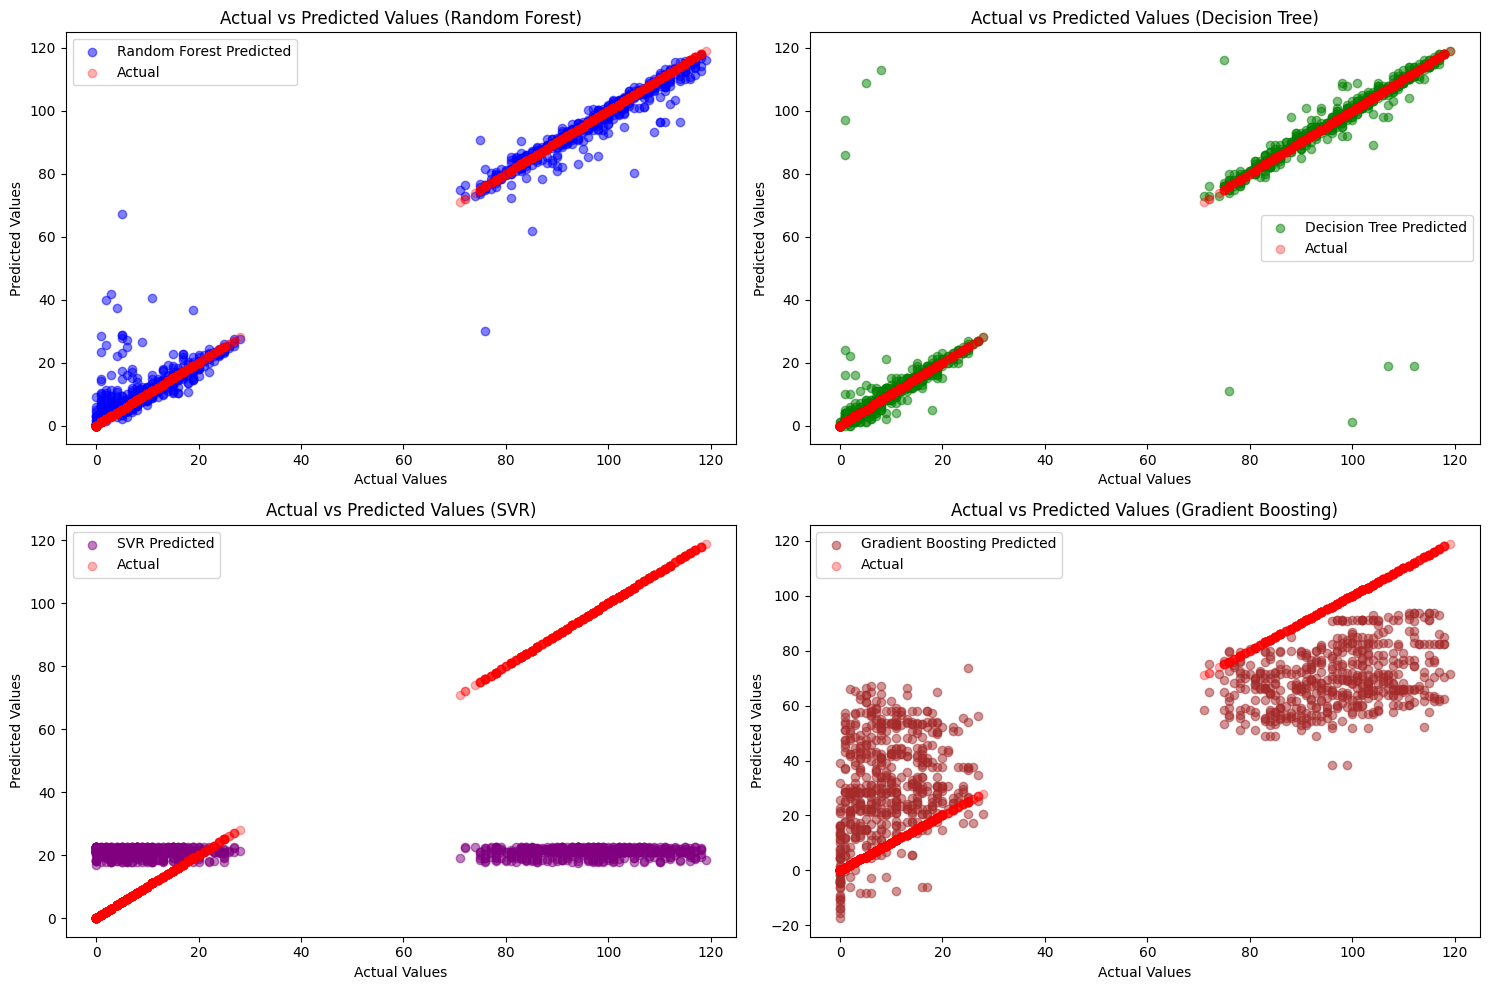

In [33]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Initialize models
RF_model = RandomForestRegressor(random_state=1)
DT_model = DecisionTreeRegressor(random_state=1)
SVR_model = SVR()
GB_model = GradientBoostingRegressor(random_state=1)

# Fit models
RF_model.fit(X_train, y_train)
DT_model.fit(X_train, y_train)
SVR_model.fit(X_train, y_train)
GB_model.fit(X_train, y_train)

# Predict on test data
y_pred_RF = RF_model.predict(X_test)
y_pred_DT = DT_model.predict(X_test)
y_pred_SVR = SVR_model.predict(X_test)
y_pred_GB = GB_model.predict(X_test)

# Calculate Mean Squared Error
mse_RF = mean_squared_error(y_test, y_pred_RF)
mse_DT = mean_squared_error(y_test, y_pred_DT)
mse_SVR = mean_squared_error(y_test, y_pred_SVR)
mse_GB = mean_squared_error(y_test, y_pred_GB)
print("Random Forest MSE:", mse_RF)
print("Decision Tree MSE:", mse_DT)
print("SVR MSE:", mse_SVR)
print("Gradient Boosting MSE:", mse_GB)

# Calculate R^2 score
score_RF = RF_model.score(X_test, y_test)
score_DT = DT_model.score(X_test, y_test)
score_SVR = SVR_model.score(X_test, y_test)
score_GB = GB_model.score(X_test, y_test)
print("Random Forest R^2 score:", score_RF)
print("Decision Tree R^2 score:", score_DT)
print("SVR R^2 score:", score_SVR)
print("Gradient Boosting R^2 score:", score_GB)

# Visualization setup
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
models = [(y_pred_RF, 'Random Forest'), (y_pred_DT, 'Decision Tree'), 
          (y_pred_SVR, 'SVR'), (y_pred_GB, 'Gradient Boosting')]
colors = ['blue', 'green', 'purple', 'brown']
labels = ['Predicted', 'Actual']

# Plot each model
for ax, (predictions, title), color in zip(axes.flatten(), models, colors):
    ax.scatter(y_test, predictions, alpha=0.5, label=f'{title} Predicted', color=color)
    ax.scatter(y_test, y_test, alpha=0.3, label='Actual', color='red')
    ax.set_xlabel('Actual Values')
    ax.set_ylabel('Predicted Values')
    ax.set_title(f'Actual vs Predicted Values ({title})')
    ax.legend()

plt.tight_layout()
plt.show()


In [34]:
import tensorflow as tf
from sklearn.preprocessing import StandardScaler

# Data Preprocessing
# Standardizing features by removing the mean and scaling to unit variance
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Build the Neural Network
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)  # Output layer: No activation function for regression
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=[tf.keras.metrics.RootMeanSquaredError(), 'mae'])

# Train the model
history = model.fit(X_train_scaled, y_train, validation_split=0.2, epochs=100, batch_size=32)

# Evaluate the model on the test data
loss, rmse, mae = model.evaluate(X_test_scaled, y_test)
print("Deep Learning Model RMSE:", rmse)
print("Deep Learning Model MAE:", mae)

# Predict on the test data
y_pred_dl = model.predict(X_test_scaled)

# Calculate R^2 score
from sklearn.metrics import r2_score
r2_score_dl = r2_score(y_test, y_pred_dl)
print("Deep Learning Model R^2 score:", r2_score_dl)


Epoch 1/100
107/107 [==============================] - 2s 5ms/step - loss: 2949.6846 - root_mean_squared_error: 54.3110 - mae: 44.0794 - val_loss: 1898.7123 - val_root_mean_squared_error: 43.5742 - val_mae: 41.8395
Epoch 2/100
107/107 [==============================] - 0s 3ms/step - loss: 1894.4059 - root_mean_squared_error: 43.5248 - mae: 41.5893 - val_loss: 1819.8225 - val_root_mean_squared_error: 42.6594 - val_mae: 40.5873
Epoch 3/100
107/107 [==============================] - 0s 3ms/step - loss: 1831.9696 - root_mean_squared_error: 42.8015 - mae: 40.7236 - val_loss: 1783.2902 - val_root_mean_squared_error: 42.2290 - val_mae: 39.9572
Epoch 4/100
107/107 [==============================] - 0s 2ms/step - loss: 1795.7865 - root_mean_squared_error: 42.3767 - mae: 40.1769 - val_loss: 1761.7368 - val_root_mean_squared_error: 41.9730 - val_mae: 39.5477
Epoch 5/100
107/107 [==============================] - 0s 4ms/step - loss: 1771.0640 - root_mean_squared_error: 42.0840 - mae: 39.7545 - val

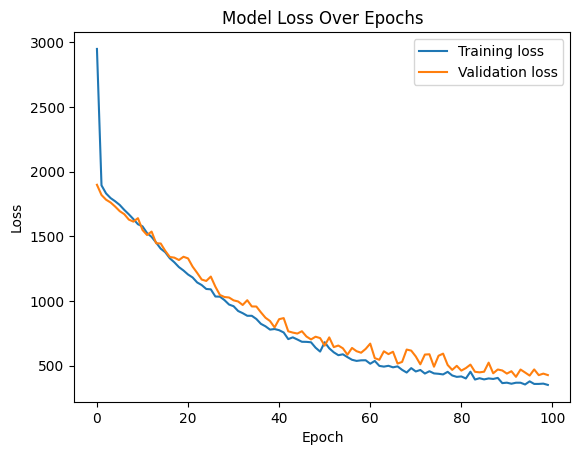

In [35]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Model Loss Over Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()